# Machine Learning and Pattern Recognition
## Assignment 1

# Q1a

1. Getting Started 

Check data dimension :  (33713280, 1)


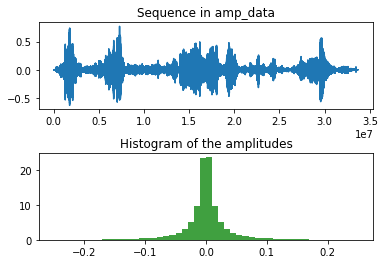

In [1]:
%matplotlib inline
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import math
import time

def DataReshape(data, col):
    #Data Reshape to C*21 and Shuffling
    row = data.shape[0] // col
    n_data = data[0:row*col, :].reshape(-1,col)
    np.random.seed(int(time.time()))
    np.random.shuffle(n_data)
    return n_data
    
def DataSplit(data, ratio):
    #Split the whole data into train, valid, test sets 
    train_flag = int(data.shape[0]*ratio[0])
    valid_flag = train_flag+1
    test_ratio = ratio[2]/(ratio[1]+ratio[2])
    test_flag = valid_flag + int((data.shape[0]-valid_flag)*(test_ratio))
    X_shuf_train = data[0:train_flag,0:20]
    y_shuf_train = data[0:train_flag,20]
    X_shuf_valid = data[valid_flag:test_flag,0:20]
    y_shuf_valid = data[valid_flag:test_flag,20]
    X_shuf_test = data[test_flag:,0:20]
    y_shuf_test = data[test_flag:,20]
    print('Check TrainSet Shape : ', X_shuf_train.shape, y_shuf_train.shape)
    print('Check ValidSet Shape : ', X_shuf_valid.shape, y_shuf_valid.shape)
    print('Check TestSet Shape : ', X_shuf_test.shape, y_shuf_test.shape)
    
    return [X_shuf_train, y_shuf_train, X_shuf_valid, y_shuf_valid, X_shuf_test, y_shuf_test]

## 1. Getting Started
print('1. Getting Started \n')
data_path = '/afs/inf.ed.ac.uk/group/teaching/mlprdata/audio/amp_data.mat'
data = io.loadmat(data_path)['amp_data']
print('Check data dimension : ', data.shape)
    
#plot histogram and linegraph
figure, ax = plt.subplots(2)
ax[0].plot(np.arange(data.shape[0]),data)
ax[0].set_title('Sequence in amp_data')
ax[1].hist(data, 50, normed=1, facecolor='g', alpha=0.75, range=[-.25, .25])
ax[1].set_title('Histogram of the amplitudes')
figure.subplots_adjust(hspace=0.5)
plt.show()

From the histogram, we note that the data seems to come from a Normal Distribution centered around zero and a relatively small standard deviation. This is good since we are not required to apply transformations (centering, scaling) to the raw data in order to start modeling. We think that maybe the data we are dealing with has been preprocessed somehow.
Also, from the sequence plot we can note the the observations are not independent of their order in what they appear. We can observe a strong local correlation among the observations. We need to shuffle the data.

# Q1b

In [2]:
#Data Reshape, Shuffling, Split
amp_data = DataReshape(data, 21)
[train_X, train_y, valid_X, valid_y, test_X, test_y] = DataSplit(amp_data, [0.7, 0.15, 0.15])

Check TrainSet Shape :  (1123775, 20) (1123775,)
Check ValidSet Shape :  (240809, 20) (240809,)
Check TestSet Shape :  (240809, 20) (240809,)


# Q2a




2. Curve fitting on a snippet of audio


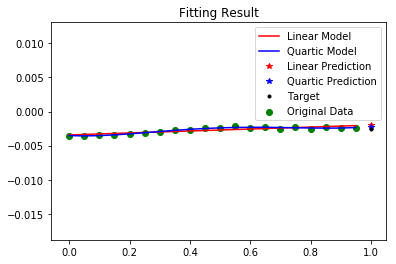

In [3]:
def PolyModelFitting(dim, input_dim, input_x, input_y):
    #Make Polynomial Model with given dimension and input data & Predict output based on this model
    #Return weights, model and prediction
    power_array = np.array([np.power(input_x,t) for t in range(1,dim)])
    data = np.concatenate([np.ones(input_dim).reshape(1,-1), power_array],axis = 0).T
    fit = np.linalg.lstsq(data, input_y)[0]
    res = np.dot(fit.reshape(1,-1),data.T)
    pred = np.dot(fit.reshape(1,-1), np.ones(dim))
    return fit, res, pred

##2. Curve fitting on a snippet of audio
print('\n\n')
print('='*100)
print('2. Curve fitting on a snippet of audio')
sample_input = np.arange(len(train_X[0]))/20.0
obs_x = train_X[0]
obs_y = train_y[0]
    
#Linear model
l_fit, l_res, l_pred = PolyModelFitting(2, 20, sample_input, obs_x)
#Quartic model
q_fit, q_res, q_pred  = PolyModelFitting(5, 20, sample_input, obs_x)
plt.figure()
plt.scatter(sample_input, obs_x, color='g', label = 'Original Data')
plt.plot(sample_input, l_res.T, 'r', label = 'Linear Model')
plt.plot(sample_input, q_res.T, 'b', label = 'Quartic Model')
plt.plot(1.0, l_pred, 'r*', label = 'Linear Prediction')
plt.plot(1.0, q_pred, 'b*', label = 'Quartic Prediction')
plt.plot(1.0, obs_y, 'k.', label='Target')
plt.title('Fitting Result')
plt.legend()
plt.show()

# Q2b 

After observing the behavior of some observations as the one in the previous example, we can note that the nature of the data is not linear. If we take only the two most recent observations and fit a linear model, we are making a very local approximation so it's highly likely that the model perform better (at least, in training set) in contrast with a model of higher contexts, where given the non linear nature of the data, it's expected that a linear model is not going to perform well.

# Q2c

Just by some visual guessing, it seems that a context length of $C=20$ and a $K=4$ could perform well. Given a large enough context length, we can make a enough good 4th order polynomial approximation that predicts well on unseen data. We would need to choose $K$ somehow objectively (by cross-validation, for example) but intuition suggest that lower values of $K$ such as $K=1$ or $K=2$ would underfit unseed data and greather values such as $K=5$ would overfit unseen data.

# Q3a

The model's prediction for the next time step is given by $f(t=1) = \mathbf{w}^{T} \mathbf{\Phi}(t=1)$ 

Now, we know that the least squares closed-form solution for $\mathbf{w}$ is given by
$\mathbf{w} = \left[ \mathbf{\Phi}^{T} \mathbf{\Phi} \right]^{-1} \mathbf{\Phi}^{T} \mathbf{x}$, where we can define a matrix $\mathbf{A}$ to be $ \mathbf{A} = \left[ \mathbf{\Phi}^{T} \mathbf{\Phi} \right]^{-1} \mathbf{\Phi}^{T}$

Therefore, substituting $\mathbf{w}$ in the expression for $f(t=1)$ gives:

$f(t=1) = \mathbf{x}^{T} \mathbf{A}^{T} \mathbf{\Phi}(t=1)$ and since $\mathbf{\Phi}(t=1) = \mathbf{e}$ where $\mathbf{e}$ is the vector of ones of length $K$, we finally get:

$f(t=1) = \mathbf{x}^{T} \mathbf{v}$ where we have defined the vector $\mathbf{v} = \mathbf{A}^{T}\mathbf{e}$

# Q3b

In [4]:
def Phi(C, K):
    phi_matrix = []
    for i in [float(t)/20.0 for t in range(20-C,20)]:
        feature = []
        for j in range(K):
            feature.append(i**j)
        phi_matrix.append(feature)
    return np.array(phi_matrix)

def make_vv(C, K):
    features = Phi(C,K)
    phi_1 = np.ones(K)
    a = np.linalg.inv(np.dot(features.T, features))
    return  np.dot(np.dot(features, a), phi_1)

def mean_squared_error(Y, X):
    return np.sum([np.power(Y-X,2)])/Y.shape[0]

##3. Choosing a polynomial predictor based on performance
print('='*100)
print('3. Choosing a polynomial predictor based on performance')
C=20
K=2
vector_K1 = make_vv(C,K)
print('\n<Compare two results from Q2 and Q3>')
print('(C,K) = ', C, K, '/ Q2 result : ', l_pred, '/ Q3 result : ', vector_K1.dot(obs_x.T))
    
C=20
K=5
vector_K4 = make_vv(C,K)
print('(C,K) = ', C, K, '/ Q2 result : ' ,q_pred, '/ Q3 result : ', vector_K4.dot(obs_x.T))

3. Choosing a polynomial predictor based on performance

<Compare two results from Q2 and Q3>
(C,K) =  20 2 / Q2 result :  [-0.00199135] / Q3 result :  -0.00199135228207
(C,K) =  20 5 / Q2 result :  [-0.00220084] / Q3 result :  -0.00220083624463


# Q3c

In [5]:
#Setting K, C gives the smallest square error
print('\n<Finding the most optimal C and K on three datasets>')
res_train = []
res_val = []
res_test = []

for C in range(2,21):
    a=[]
    b=[]
    c=[]
    for K in range(2,10):
        vector = make_vv(C,K)
        a.append(mean_squared_error(train_y, vector.dot(train_X[:,20-C:20].T)))
        b.append(mean_squared_error(valid_y, vector.dot(valid_X[:,20-C:20].T)))
        c.append(mean_squared_error(test_y, vector.dot(test_X[:,20-C:20].T)))
    res_train.append(a)
    res_val.append(b)
    res_test.append(c)

    
#Train Error
res_train = np.array(res_train)
arg_min  = res_train.argmin()
ravel = res_train.ravel()[res_train.argmin()]
div_m = divmod(arg_min, ravel)
print('\nC&K making the lowest err on the train set : ',div_m[0]+2, div_m[1]+2)
print('Train Set Err : ', res_train[int(div_m[0]),int(div_m[1])])
    
#Validation Error
res_val = np.array(res_val)
arg_min  = res_val.argmin()
ravel = res_val.ravel()[arg_min]
div_m = divmod(arg_min, ravel)
print('\nC&K making the lowest err on the validation set : ',div_m[0]+2, div_m[1]+2)
print('Valid Set Err : ', res_train[int(div_m[0]),int(div_m[1])])    
    
#Test Error 
res_test = np.array(res_test)
arg_min  = res_test.argmin()
ravel = res_test.ravel()[arg_min]
print('\nC&K making the lowest err on the test set : ',div_m[0]+2, div_m[1]+2)
print('Test Set Err : ' ,res_train[int(div_m[0]),int(div_m[1])])


<Finding the most optimal C and K on three datasets>

C&K making the lowest err on the train set :  2.0 2.0
Train Set Err :  1.34237746701e-05

C&K making the lowest err on the validation set :  2.0 2.0
Valid Set Err :  1.34237746701e-05

C&K making the lowest err on the test set :  2.0 2.0
Test Set Err :  1.34237746701e-05


# Q4a

In [6]:
def linearprediction_squared_error(Y, vector, X):
    return np.sum([np.power(Y-vector.T.dot(X),2)])/Y.shape[0]

def LinearPredictor(Y, X , C):
    # Predict using linear predictor
    n_X = X[:,19-C:20]
    A = np.dot(np.linalg.inv(np.dot(n_X.T,n_X)), n_X.T)
    pred = np.dot(A,Y)
    return pred

def Residual(Y, X, C):
    pred = LinearPredictor(Y,X,C)
    residual = np.dot(X[:,19-C:20],pred)-Y
    return residual

## 4. Fitting linear predictors across many snippets
print('\n\n')
print('='*100)
print('4. Fitting linear predictors across many snippets')
linear_train_err = []
linear_valid_err = []
predictors = []
    
for C in range(20):
    train_pred = LinearPredictor(train_y, train_X, C)
    linear_train_err.append(linearprediction_squared_error(train_y, train_pred.reshape(-1,1), train_X[:, 19-C:20].T)) 
    linear_valid_err.append(linearprediction_squared_error(valid_y, train_pred.reshape(-1,1), valid_X[:, 19-C:20].T))
    predictors.append(train_pred)
    
train_C = np.array(linear_train_err).argmin()+1
valid_C = np.array(linear_valid_err).argmin()+1
    
print(' ')
print('C making the lowest mean square err on the training set and the err: ',train_C, linear_train_err[train_C-1])
print('C making the lowest mean square err on the validation set and the err: ',valid_C, linear_valid_err[valid_C-1])




4. Fitting linear predictors across many snippets
 
C making the lowest mean square err on the training set and the err:  20 7.60513475203e-06
C making the lowest mean square err on the validation set and the err:  14 7.67733049985e-06


The context length $C=20$ is the one with lowest *MSE* on both the training and validation sets.
As now we have a simpler linear model, the context length parameter $C$ is our only complexity parameter. As long as we increase this parameter, we are getting better results on both sets of data. It is very likely that if we had longer context lengths, eventually we would observe a decrease on the performance on validation data. Nevertheless, with the value $C=20$ it seems we are not reaching that inflexion point yet.

# Q4b

In [7]:
test_pred = predictors[valid_C-1]
linear_test_err = linearprediction_squared_error(test_y, test_pred.reshape(-1,1), test_X[:, 19-(valid_C-1):20].T)

print('Test Set Error of best polynomial model: ' ,res_test[int(div_m[0]),int(div_m[1])])
print('Test Set Error of best linear model: ' ,linear_test_err)

Test Set Error of best polynomial model:  1.41606575722e-05
Test Set Error of best linear model:  8.43858319888e-06


The results obtained suggest that the standard least squares approach is better, since we are obtaining a *MSE* of magnitude $10^{-6}$ on test set, while with the polynomial approach the *MSE* es of magnitude $10^{-5}$.

# Q4c


<Plotting a histogram of the residuals on the validation data>


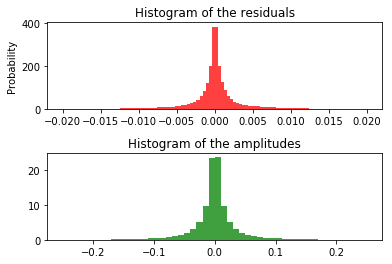

In [8]:
print('\n<Plotting a histogram of the residuals on the validation data>')
    
valid_residual = Residual(valid_y, valid_X, 20)
figure, ax = plt.subplots(2)
ax[0].hist(valid_residual, 100, normed=1, facecolor='r', alpha=0.75, range=[-.02, .02])
ax[0].set_ylabel('Probability')
ax[0].set_title('Histogram of the residuals')
ax[1].hist(data, 50, normed=1, facecolor='g', alpha=0.75, range=[-.25, .25])
ax[1].set_title('Histogram of the amplitudes')
figure.subplots_adjust(hspace=0.5)
plt.show()

Similary to the raw data plotted at the beggining, the residuals on validation set seems to follow a Normal Distribution centered around zero and a even smaller standard deviation. Since this distribution is obtained over the validation data, we can conclude that so far, our system is performing well. We are obtaining a zero residual on average with small variability.

# Q5

Suggested incremental approaches:
    
* Perform $l_2$ regularization to try to avoid overfitting and improve generalization error.
* Perform the training step with an iterative algorithm rather than with the (costly and numerical unstable) closed form solution. In fact, we can try with *SGD* so the iterations can be faster and inexpensive.
* Try longer context lengths, $C>20$ (More data points will be necessary.)
* Code below is the example of adding regularisation for some lambda value.

Lambda is  0.1
C making the lowest regularization cost on the training set and the cost:  1 0.0978550278953
C making the lowest regularization cost on the validation set and the cost:  1 0.0978550461658 

Lambda is  0.010000000000000002
C making the lowest regularization cost on the training set and the cost:  1 0.00981851145007
C making the lowest regularization cost on the validation set and the cost:  1 0.00981852972051 

Lambda is  0.0010000000000000002
C making the lowest regularization cost on the training set and the cost:  1 0.00101485980555
C making the lowest regularization cost on the validation set and the cost:  1 0.00101487807598 

Lambda is  0.00010000000000000002
C making the lowest regularization cost on the training set and the cost:  1 0.000134494641093
C making the lowest regularization cost on the validation set and the cost:  1 0.000134512911532 

Lambda is  1.0000000000000003e-05
C making the lowest regularization cost on the training set and the cost:  1 4.64581

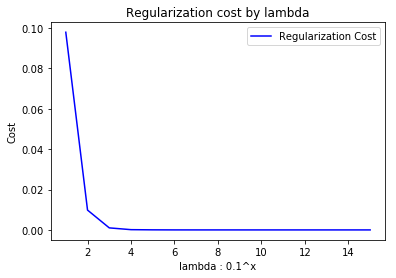

The best lamb and C are :  1e-15 14
Test Set Error of best linear model:  8.43858319888e-06


In [20]:
def linearprediction_regularization(Y, vector, X, lam):
    return np.sum([np.power(Y-vector.T.dot(X),2)])/Y.shape[0]+lam*np.sum(vector**2)

regular_err_ex = []
min_C = []
predictors = []

for ex in range(1,16):
    regular_train_err = []
    regular_valid_err = []
    train_p = []
    lamb = 0.1**ex
    for C in range(20):
        train_pred = LinearPredictor(train_y, train_X, C)
        regular_train_err.append(linearprediction_regularization(train_y, train_pred.reshape(-1,1), train_X[:, 19-C:20].T,lamb)) 
        regular_valid_err.append(linearprediction_regularization(valid_y, train_pred.reshape(-1,1), valid_X[:, 19-C:20].T,lamb))
        train_p.append(train_pred)
        
    train_regC = np.array(regular_train_err).argmin()+1
    valid_regC = np.array(regular_valid_err).argmin()+1
    
    print('Lambda is ', lamb)
    print('C making the lowest regularization cost on the training set and the cost: ',train_regC, regular_train_err[train_regC-1])
    print('C making the lowest regularization cost on the validation set and the cost: ',valid_regC, regular_valid_err[valid_regC-1],'\n')
    regular_err_ex.append(regular_valid_err[valid_regC-1])
    min_C.append(valid_regC)
    predictors.append(train_p[valid_regC-1])
    
plt.plot(np.arange(15)+1, regular_err_ex, 'b', label = 'Regularization Cost')
plt.title('Regularization cost by lambda')
plt.xlabel('lambda : 0.1^x')
plt.ylabel('Cost')
plt.legend()
plt.show()

regular_err_ex=np.array(regular_err_ex)
ideal_lamb = 0.1**(regular_err_ex.argmin()+1)
ideal_C = min_C[regular_err_ex.argmin()]

print('The best lamb and C are : ', ideal_lamb, ideal_C)

test_pred = predictors[regular_err_ex.argmin()]
linear_test_err = linearprediction_squared_error(test_y, test_pred.reshape(-1,1), test_X[:, 19-(ideal_C-1):20].T)

print('Test Set Error of best linear model: ' ,linear_test_err)